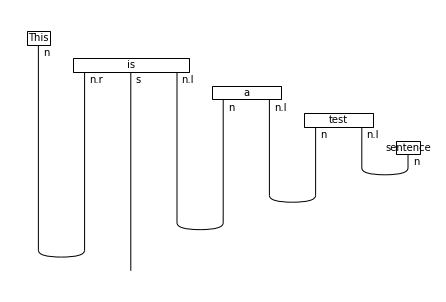

In [1]:
from lambeq.ccg2discocat import DepCCGParser

depccg_parser = DepCCGParser()
diagram = depccg_parser.sentence2diagram('This is a test sentence')
diagram.draw()

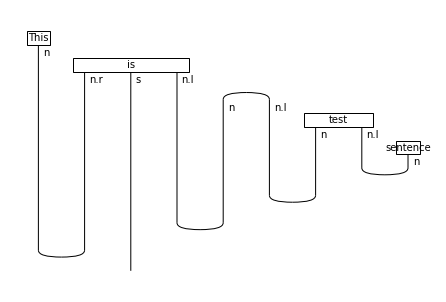

In [2]:
from lambeq.rewrite import Rewriter

rewriter = Rewriter(['prepositional_phrase', 'determiner'])
d = rewriter(diagram)
d.draw()

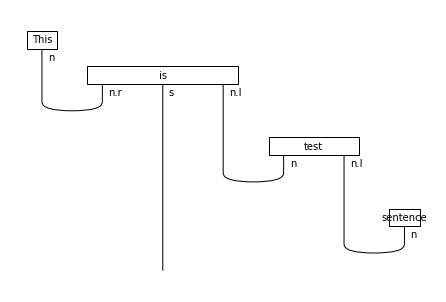

In [3]:
d.normal_form().draw()

In [4]:
import warnings
warnings.filterwarnings('ignore')  # Ignore warnings

from discopy.tensor import Tensor
import numpy as np


np.random.seed(123458)  # Fix the seed

In [5]:
# Read data

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            labels.append([1, 0] if line[0] == '1' else [0, 1])
            sentences.append(line[1:].strip())
    return np.array(labels), sentences


train_labels, train_data = read_data('data/mc_train_data.txt')
dev_labels, dev_data = read_data('data/mc_dev_data.txt')
test_labels, test_data = read_data('data/mc_test_data.txt')

In [6]:
train_data[:10]

['skillful man prepares sauce',
 'skillful man bakes dinner',
 'woman cooks tasty meal',
 'man prepares meal',
 'skillful woman debugs program',
 'woman prepares tasty meal',
 'person runs program',
 'person runs useful application',
 'woman prepares sauce',
 'woman prepares dinner']

In [7]:
train_labels[:5]

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1]])

In [8]:
from lambeq.ccg2discocat import DepCCGParser

# parser = DepCCGParser()
# train_diagrams = parser.sentences2diagrams(train_data)
# test_diagrams = parser.sentences2diagrams(test_data)

reader = DepCCGParser(possible_root_cats=['S[dcl]'])

raw_train_diagrams = reader.sentences2diagrams(train_data)
raw_dev_diagrams = reader.sentences2diagrams(dev_data)
raw_test_diagrams = reader.sentences2diagrams(test_data)

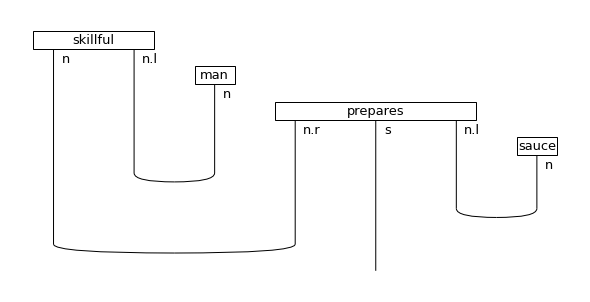

In [9]:
raw_train_diagrams[0].draw(figsize=(8,4), fontsize=13)

In [10]:
from discopy.rigid import Id


def remove_cups(diagram):
    # Remove cups to reduce post-selection in the circuit, for faster execution

    diags = []
    for box, offset in zip(diagram.boxes, diagram.offsets):
        if not box.dom:  # word box
            diags.insert(offset, box)
        else:  # cup (the only other type of box in these diagrams)
            i = 0
            off = offset
            while off != len(diags[i].cod) - 1:
                assert off > 0
                off -= len(diags[i].cod)
                i += 1
            left, right = diags[i:i+2]
            
            if len(left.cod) == 1:
                new_diag = right >> (left.r.dagger() @ Id(right.cod[1:]))
            else:
                assert len(right.cod) == 1
                new_diag = left >> (Id(left.cod[:-1]) @ right.l.dagger())

            diags[i:i+2] = [new_diag]

    assert len(diags) == 1
    return diags[0]


train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

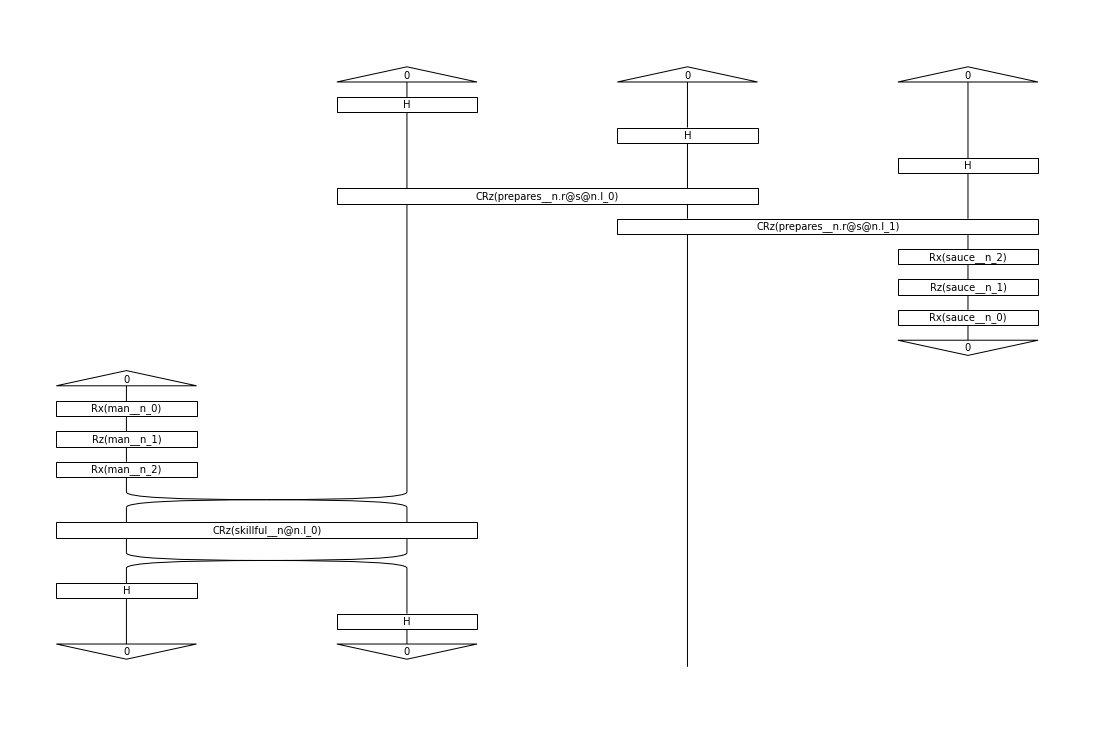

In [11]:
from lambeq.circuit import IQPAnsatz
from lambeq.tensor import SpiderAnsatz
from lambeq.core.types import AtomicType

# Define atomic types
N = AtomicType.NOUN
S = AtomicType.SENTENCE

# Convert string diagram to quantum circuit
ansatz = IQPAnsatz({N: 1, S: 1}, n_layers=1)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

all_circuits = train_circuits + dev_circuits + test_circuits

train_circuits[0].draw(figsize=(15,10))

In [12]:
from sympy import default_sort_key

vocab = sorted(
   {sym for c in all_circuits for sym in c.free_symbols},
    key=default_sort_key
)
vocab_vals = np.random.rand(len(vocab))

print(vocab)
print(len(vocab_vals))

[application__n_0, application__n_1, application__n_2, bakes__n.r@s@n.l_0, bakes__n.r@s@n.l_1, cooks__n.r@s@n.l_0, cooks__n.r@s@n.l_1, debugs__n.r@s@n.l_0, debugs__n.r@s@n.l_1, debugs__n@n.l_0, dinner__n_0, dinner__n_1, dinner__n_2, man__n.r@s@n.l_0, man__n.r@s@n.l_1, man__n_0, man__n_1, man__n_2, meal__n_0, meal__n_1, meal__n_2, person__n_0, person__n_1, person__n_2, prepares__n.r@s@n.l_0, prepares__n.r@s@n.l_1, program__n_0, program__n_1, program__n_2, runs__n.r@s@n.l_0, runs__n.r@s@n.l_1, sauce__n_0, sauce__n_1, sauce__n_2, skillful__n@n.l_0, skillful__n_0, skillful__n_1, skillful__n_2, software__n_0, software__n_1, software__n_2, tasty__n@n.l_0, useful__n@n.l_0, woman__n_0, woman__n_1, woman__n_2]
46


In [13]:
from pytket.extensions.qiskit import AerBackend, IBMQBackend, IBMQEmulatorBackend
from discopy.quantum import Circuit, Id, Measure

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'n_shots': 6192,
}

def normalise_prediction(pred):
    # see section 7.2 of https://arxiv.org/pdf/2102.12846.pdf
    pred = np.abs(pred.array - 1e-9)
    return pred / pred.sum()

def make_pred_fn(circuits, **kwargs):
    measured_circuits = [c >> Id().tensor(*[Measure()] * len(c.cod)) for c in circuits]
    
    # Bind parameter symbols to circuits
    circuit_functions = [c.lambdify(*vocab) for c in measured_circuits]
   
    # Compute predictions
    def predict(params):
        outputs = Circuit.eval(
            *(circuit_fn(*params) for circuit_fn in circuit_functions),
            **backend_config,
            seed=123
        )
        return np.array([normalise_prediction(output) for output in outputs])

    return predict

def make_loss_fn(predict_fn, labels):
    def loss(params, **kwargs):
        predictions = predict_fn(params)

        # binary cross-entropy loss
        cost = -np.sum(labels * np.log2(predictions)) / len(labels)
        costs.append(cost)
        
        acc = np.sum(np.round(predictions) == labels) / len(labels) / 2  # half due to double-counting for two element predictions
        accuracies.append(acc)
        
        return cost
    
    costs, accuracies = [], []
    return loss, costs, accuracies

In [14]:
train_pred_fn = make_pred_fn(train_circuits)
dev_pred_fn = make_pred_fn(dev_circuits)
test_pred_fn = make_pred_fn(test_circuits)

train_cost_fn, train_costs, train_accs = make_loss_fn(train_pred_fn, train_labels)
dev_cost_fn, dev_costs, dev_accs = make_loss_fn(dev_pred_fn, dev_labels)

In [15]:
for i,v in enumerate(vocab_vals):
    print(v)

0.3574339461963959
0.4576441801977128
0.5009618609698835
0.19143722412695752
0.5540817916435609
0.2890580666841597
0.4797648889536389
0.7871024450860739
0.8471331261998809
0.4284091717975105
0.8823882503908519
0.9400893869019179
0.1526143128791445
0.24257567435788008
0.4094013940864547
0.6182152445779603
0.42484349262060206
0.3601854968801561
0.5729150196897964
0.2217057299167704
0.9165956788003773
0.175356967938882
0.7768798941243484
0.2861096840245416
0.9452344190131634
0.6291670826911151
0.9177418880617813
0.8960986922854801
0.26136568265198046
0.8460334895164334
0.3290390778158645
0.19545711312451985
0.7037831008344659
0.9549563977003144
0.6878782063110115
0.4381696916561406
0.8258143048435941
0.6840794060383745
0.05491503988556734
0.6271894324770992
0.8178166696631003
0.8537688672136188
0.15775276026460128
0.6529115884348622
0.485470342988667
0.9714231423256056


In [16]:
from noisyopt import minimizeSPSA

result = minimizeSPSA(train_cost_fn, x0=vocab_vals, a=0.2, c=0.06, niter=80, callback=dev_cost_fn)

# result = minimizeSPSA(train_cost_fn, x0=vocab_vals, niter=20)

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [13]:
embedding = {
    'vocab': vocab,
    'vals': list(result.x)
}

In [14]:
import pickle
embedding = {
    'vocab': vocab,
    'vals': list(result.x)
}
with open('saved_embedding.pkl', 'wb') as f:
    pickle.dump(embedding, f)
        
# with open('saved_embedding.pkl', 'rb') as f:
#     loaded_dict = pickle.load(f)
# 
# loaded_dict

In [ ]:
for i,v in enumerate(params):
    print(v)

    
# 0.3574339461963959
# 0.4576441801977128
# 0.5009618609698835
# 0.19143722412695752

In [ ]:
import matplotlib.pyplot as plt

# print(costs)x

plt.plot(dev_costs[1::2])
plt.title("Training")
plt.ylabel('Cost')

In [ ]:
plt.plot(train_accs[1::2])
plt.title("Training")
plt.ylabel('Accuracy')

In [ ]:
for v in vocab_vals:
    print(v)

In [ ]:
accuracies

In [ ]:
t_train_preds = make_pred_fn(train_circuits[:3])
loss, costs, accuracies = make_loss_fn(t_train_preds, train_targets[:3])

loss(vocab_vals)

In [ ]:
loss(vocab_vals)

In [ ]:
a[0].array

In [ ]:
b = np.array(a[0].array)
b /= b.sum()
b

In [ ]:
a = loss(vocab_vals)
a

In [ ]:
a

In [ ]:
t = train_circuits[1] >> Id().tensor(Measure())

In [ ]:
# render_circuit_jupyter(t.to_tk())

In [ ]:
from jax import jit, grad

training_loss = jit(loss)
gradient = jit(grad(loss))

In [ ]:
from noisyopt import minimizeSPSA


In [ ]:
# result = minimizeSPSA(loss, x0=vocab_vals, niter=10)

In [ ]:
gradient(vocab_vals)

In [ ]:
training_losses = []

epochs = 90

for i in range(epochs):
    print(i)
    gr = gradient(vocab_vals)
    for k in range(len(vocab_vals)):
        vocab_vals[k] = vocab_vals[k] - gr[k] * 1.0

    training_losses.append(float(training_loss(vocab_vals)))

    if (i + 1) % 10 == 0:
        print(f"Epoch {i + 1} - loss {training_losses[-1]}")

In [ ]:
train_targets[0] *np.log2(prob_distribution) 

In [ ]:
circuit_2param.parameters
